# Brain Tumor Classification
## Introduction
Brain tumors are abnormal cell growths in the brain that can seriously harm a person's health and quality of life. Effective brain tumor management and therapy depend on a timely and correct diagnosis. Magnetic Resonance Imaging (MRI), a potent non-invasive imaging method, is essential for the identification and categorization of brain tumors.  
Artificial Intelligence can be very helpful in classifying different types of brain tumors according to the imaging traits and patterns that can be seen during MRI scans. To help with treatment planning and decision-making, this classification offers valuable information to medical practitioners.  
The examination of different imaging data, such as tumor form, enhancing pattern, edema, and presence of necrosis, is required for the classification of brain tumors using MRI. These factors are analyzed by radiologists and sophisticated computer algorithms to classify cancers into various grades or categories, which are crucial for treatment planning and prognosis evaluation.  
The categorization of brain tumors using MRI has undergone a radical change recently thanks to developments in machine learning and artificial intelligence. To effectively detect brain tumors, AI algorithms can process massive amounts of MRI data and extract useful information. These methods have the potential to increase patient outcomes, decrease human error, and increase diagnostic accuracy.  

### Aim and Objectives
This report aims at using a Deep Learning algorithm to classify MRI scans relating exclusively to brain tumors in order to learn and consequently be able to identify the different classes of brain tumors. The objectives we aim to achieve in this project are as follows:  
1. Data cleaning and Preprocessing.  
2. Building a Convolution Neural Network to model the data.  
3. Evaluating the model.  
4. Testing the model with new-comer data.  

### The data
The MRI scan images used for this task was obtained online [The link here](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset). It contains 7023 images of human brain MRI scans which are grouped into 4 classes namely: **glioma**, **meningioma**, **no_tumor**, and **pituitary**.


In [1]:
# Load necessary libraries
import os
import random
import imagehash # For checking duplicate images
from PIL import Image
import imghdr
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# Define paths for images
dataset_path = "C:\\Users\\DELL PC\\Desktop\\convolNeuralNet\\training"
validation_path = "C:\\Users\\DELL PC\\Desktop\\convolNeuralNet\\testing"

\newpage

## Tools and setup
The tools used for this project are Jupyter notebok and python. The libraries used are OS, random, imagehash, PIL, imghdr, OpenCV(cv2), NumPy, matplotlib, tensorflow, and skikit learn.  
In order to successfully build an image classification model, these steps are taken to ensure we achieve our objectives:  
1. We define the paths to our data for both training and validation sets.  
2. Since image neural network algorithms utilise the system GPUs, we create a memory guard to make sure tensorflow use the needed GPU size and leave the rest unused.   

In [3]:
# set GPU Memory Consumption to avoid OOM errors (To make tensorflow use needed GPU memory and nothing more)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Data Cleaning and Preprocessing
In order to handle inconsistencies and irregularities in the dataset, it is of utmost importance that we clean the dataset. A clean dataset generates more reliable results. The steps taken to clean and preprocess the images are as follows:  
1. Our pipeline is designed to consider filtering acceptable image extensions, discarding unacceptable extensions. The acceptable extensions in our case are: **.jpg**, **.jpeg**, **.png**.  
2. We made sure duplicate images are taken out as they may likely cause overfitting in the model training.  
3. One of the preprocessing steps taken was to resize all images to a uniform size of 224 x 224 pixels.  
4. We further preprocessed the images by scaling the pixel values in the range 0-1.  
5. Finally, we converted the labels as one hot encoding.  

Below are the pixel values range after being preprocessed.  

In [4]:
# Make the model use acceptable file extensions
image_exts = ['jpg','jpeg','png']

In [5]:
# Drop useless images
for image_class in os.listdir(dataset_path):
    for image in os.listdir(os.path.join(dataset_path,image_class)):
        image_path = os.path.join(dataset_path, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}', format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'. format(image_path))

In [8]:
# Data cleaning
# Function to remove duplicate images
def remove_duplicates(path):
    hashes = {}
    duplicate_images = []

    for folder_name in os.listdir(path):
        folder_path = os.path.join(path, folder_name)
        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                with Image.open(image_path) as image:
                    image_hash = str(imagehash.average_hash(image))
                    if image_hash in hashes:
                        duplicate_images.append(image_path)
                    else:
                        hashes[image_hash] = image_path

    # Remove duplicate images
    for duplicate_image in duplicate_images:
        os.remove(duplicate_image)
        print(f"Removed duplicate image: {duplicate_image}")

# Remove duplicates from the dataset
remove_duplicates(dataset_path)

In [5]:
def load_dataset(path):
    images = []
    labels = []
    
    subfolders = os.listdir(path)
    for i, subfolder in enumerate(subfolders):
        subfolder_path = os.path.join(path, subfolder)
        for image_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_name)
            image = cv2.imread(image_path)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))  # Adjust the size as needed
            images.append(image)
            labels.append(i)
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

# Load the dataset
images, labels = load_dataset(dataset_path)

# Split the dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=100)

In [6]:
# Preprocess the images
train_images = train_images / 255.0  # Normalize pixel values between 0 and 1
test_images = test_images / 255.0

# Convert labels to one-hot encoding
num_classes = len(np.unique(labels))
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

In [7]:
# Check that its scaled
print(f"minimum: ",train_images[0].min(), 'maximum: ',train_images[0].max())

minimum:  0.0 maximum:  1.0


The images below show one sample each of the classes of brain tumor MRI scans.  

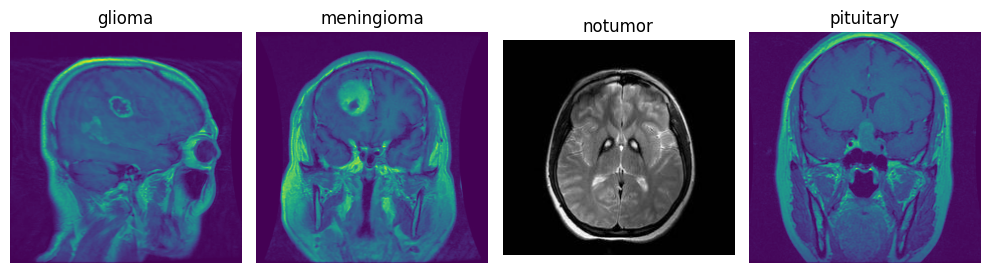

In [8]:
# Function to display a random image from each folder
def display_images_from_folders(path):
    fig = plt.figure(figsize=(10, 4))
    
    columns = 4
    rows = 1
    
    for i, folder_name in enumerate(os.listdir(path)):
        folder_path = os.path.join(path, folder_name)
        if os.path.isdir(folder_path):
            image_names = os.listdir(folder_path)
            if image_names:
                random_image_name = random.choice(image_names)
                image_path = os.path.join(folder_path, random_image_name)
                with Image.open(image_path) as image:
                    ax = fig.add_subplot(rows, columns, i+1)
                    ax.imshow(image)
                    ax.set_title(folder_name)
                    ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display an image from each folder in a grid
display_images_from_folders(dataset_path)

## Methodology
In this section, we discuss the methods used in this image classification task. We employ the Convolutional Neural Network (CNN) with multiple layers and some activation functions.    

### Convolutional Neural Network (CNN)
Convolutional Neural Network (CNN) is a deep learning algorithm created specifically for the analysis of images. CNNs are frequently employed for computer vision tasks such picture segmentation, object identification, and classification. The ability of CNNs to automatically learn and extract pertinent information from the incoming data is its distinguishing characteristic. Convolutional layers are used to accomplish this, applying filters to the input image to capture regional patterns and spatial correlations. These filters pick up on a range of characteristics, including edges, textures, and forms.  

Additionally, CNNs use pooling layers that downsample the feature maps, lowering the spatial dimensions while retaining crucial details. As a result, the model can recognize items regardless of where they are in the image. The extracted features are input into fully connected layers after many convolutional and pooling layers, which conduct high-level synthesis and produce predictions based on the learnt features. To reduce the prediction error, the model is trained using a sizable labeled dataset while modifying the weights and biases using gradient descent and backpropagation.

When it comes to picture classification tasks, CNNs outperform more conventional machine learning techniques. They are very proficient at comprehending and interpreting complicated visual patterns because of their capacity to automatically develop hierarchical representations from unprocessed pixel input.

Mathematically, CNN can be represented as given below:  

\begin{equation}
y = f \left( W \ast x + b \right)
\end{equation}

where:

$y$ is the output of the CNN  
$f$ is an activation function  
$W$ is the weight matrix  
$x$ is the input data  
$b$ is the bias term  

### Activation functions
In a neural network, activation functions are mathematical operations that are applied to each neuron's output. By adding non-linearity, they enable the network to learn complex patterns and produce more precise predictions. Based on the weighted total of a neuron's inputs, activation functions determine the output of the neuron. We discuss the activation functions used in our modeling phase:  
1. Rectified Linear Unit (ReLU) is one of the most widely used activation functions in deep learning. It is defined as:  

$$ReLU(x) = max(0, x)$$

- ReLU produces the same value in this function if the input x is positive, but it produces zero if x is negative.  

2. Softmax takes a vector of real numbers as input and transforms them into a probability distribution. The softmax function is defined as:  

$$Softmax(x_i) = exp(x_i) / sum(exp(x_j)) for all j$$

- Here, the denominator is the sum of the exponential values of all the components in the input vector, and $x_i$ stands for the input vector's member i.  
- Softmax is used mostly for multi-class classification problems.  

### Model Evaluation metrics
Accuracy and loss are two typical measures used in deep learning to assess a model's performance during the training and testing phases. They are defined as follows:  

1. **Accuracy** measures how well a model predicts the appropriate labels or classifications for the supplied inputs. It is described as the proportion between the number of accurate guesses and all predictions. It shows the proportion of accurate predictions the model made. A higher accuracy is often preferred because it shows that the model is producing more accurate predictions. But accuracy by itself could not give a whole view of the model's performance, particularly when the dataset is unbalanced or when various classes have varied relative weights.  

2. **Loss**, also referred to as the cost or objective function, measures the difference between the model's expected results and the actual labels. It stands for the difference between the predictions made by the model and what they should have been. A smaller loss implies that the model is learning to generate better predictions, and minimizing the loss is the aim of the training process.    







### The Model
In the modeling phase, we partition our data into train and test sets in the ratio of 80:20. This CNN model we built has several layers, each of which has a unique set of parameters. Let's go through each layer and its parameters:  

1. Conv2D Layer (32 filters, kernel size 3x3, activation='relu'):  
- 32 filters: This layer applies 32 filters or kernels, each of size 3 by 3, to the incoming data. The input volume is slid over by these filters to extract various features.  
- Activation function: The 'relu' activation function is applied element-wise to the output of this layer, introducing non-linearity to the model.  

2. Maximum Pooling (2x2) Layer:  
- Pool size: This layer uses maximum pooling, which applies a 2x2 window to the output of the layer below. The feature map is downsampled after choosing each window's highest value.  

3. Conv2D Layer (64 filters, a 3x3 kernel, and an activation of "relu"):  
- This layer similarly applies 64 filters of size 3x3 to the input feature map like the first Conv2D layer did.  
- To provide non-linearity, the activation function'relu' is used once more.  

4. Maximum Pooling (2x2) Layer:  
- Max pooling is carried out with a 2x2 window, further downsampling the feature map.  

5. Flatten Layer:  
- The 2D feature maps are transformed into 1D vectors by this layer. The input volume is transformed into a flat array that will serve as the input for the succeeding fully connected layers.  

7. (128 units, activation='relu') Dense Layer:  
- A layer of 128 units (neurons) with complete connectivity.
- The output of this layer is activated using the'relu' activation function.  

8. Dense Layer: (num_classes units, softmax activation)  
- 'num_classes' units make up the final fully linked layer, where 'num_classes' denotes the number of output classes in the classification process.  
- The output is transformed into class probabilities using the'softmax' activation function.  

9. Adam, an adaptive optimization algorithm, is selected as the optimizer for model compilation. With "CategoricalCrossentropy" as the loss function, multi-class classification tasks can be solved since in our case, we are dealing with multi-class classification task.  


Below are the model training logs for each epoch. We set epochs = 10 and out batch size = 32 for this task.  

In [13]:
# Create the CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data= (test_images,test_labels))

Epoch 1/10
87/87 [==============================] - 194s 2s/step - loss: 1.0032 - accuracy: 0.5970 - val_loss: 0.6502 - val_accuracy: 0.7362
Epoch 2/10
87/87 [==============================] - 181s 2s/step - loss: 0.5190 - accuracy: 0.7922 - val_loss: 0.6485 - val_accuracy: 0.7101
Epoch 3/10
87/87 [==============================] - 180s 2s/step - loss: 0.3304 - accuracy: 0.8752 - val_loss: 0.3893 - val_accuracy: 0.8435
Epoch 4/10
87/87 [==============================] - 179s 2s/step - loss: 0.1723 - accuracy: 0.9365 - val_loss: 0.3550 - val_accuracy: 0.8609
Epoch 5/10
87/87 [==============================] - 165s 2s/step - loss: 0.1250 - accuracy: 0.9565 - val_loss: 0.3373 - val_accuracy: 0.8884
Epoch 6/10
87/87 [==============================] - 166s 2s/step - loss: 0.0574 - accuracy: 0.9811 - val_loss: 0.3364 - val_accuracy: 0.8826
Epoch 7/10
87/87 [==============================] - 162s 2s/step - loss: 0.0486 - accuracy: 0.9844 - val_loss: 0.3654 - val_accuracy: 0.8855
Epoch 8/10
87

The model gets evaluated at each epoch and below is a plot showing the evaluation metrics for training and validation sets. The Accuracy and loss per epoch are shown in the plot below.  

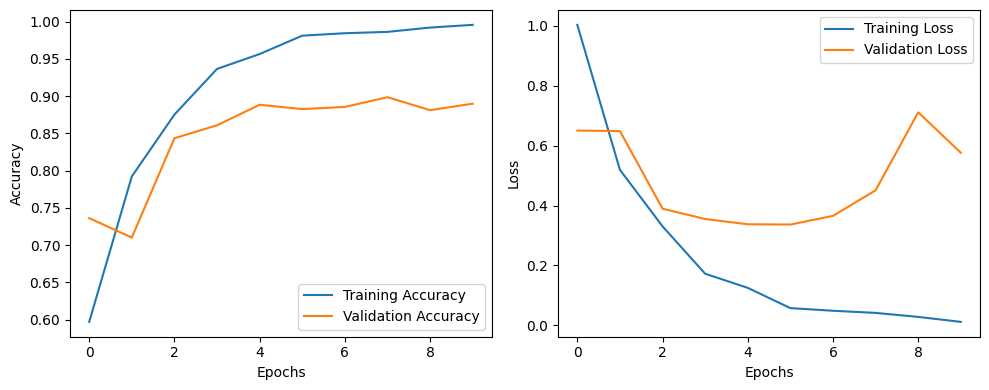

In [14]:
plt.figure(figsize=(10, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()


Below is the final model evaluation result. The model is able to perform well in classifying brain tumor from MRI scans with an accuracy and loss given below.   

In [15]:
# Model evaluation om test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

22/22 [==============================] - 11s 510ms/step - loss: 0.5761 - accuracy: 0.8899
Test Loss: 0.5761
Test Accuracy: 0.8899


We saved some unseen images for validation of the model. We compared the Ground truth with the prediction and the model prediction performance is shown below. We may observe from the prediction that the model performs a bit poorly in predicting **glioma**, but performed very good predicting other classes.  

In [18]:
# Load the dataset
validation_images, validation_labels = load_dataset(validation_path)
predictions = model.predict(validation_images)

# Create a mapping between numerical labels and folder names
label_mapping = {0: 'glioma', 1: 'meningioma', 2: 'no_tumor', 3: 'pituitary'}

# Decode the predictions
predicted_labels = np.argmax(predictions, axis=1)
decoded_predicted_labels = [label_mapping[label] for label in predicted_labels]
decoded_validation_labels = [label_mapping[label] for label in validation_labels]


# Display the ground truth and predicted labels side by side
for i in range(len(decoded_validation_labels)):
    print("Ground Truth:", decoded_validation_labels[i], "--", "Predicted:", decoded_predicted_labels[i])

2/2 [==============================] - 1s 153ms/step
Ground Truth: glioma -- Predicted: no_tumor
Ground Truth: glioma -- Predicted: no_tumor
Ground Truth: glioma -- Predicted: meningioma
Ground Truth: glioma -- Predicted: no_tumor
Ground Truth: glioma -- Predicted: meningioma
Ground Truth: glioma -- Predicted: meningioma
Ground Truth: glioma -- Predicted: no_tumor
Ground Truth: glioma -- Predicted: meningioma
Ground Truth: glioma -- Predicted: glioma
Ground Truth: glioma -- Predicted: glioma
Ground Truth: meningioma -- Predicted: meningioma
Ground Truth: meningioma -- Predicted: meningioma
Ground Truth: meningioma -- Predicted: meningioma
Ground Truth: meningioma -- Predicted: meningioma
Ground Truth: meningioma -- Predicted: meningioma
Ground Truth: meningioma -- Predicted: meningioma
Ground Truth: meningioma -- Predicted: meningioma
Ground Truth: meningioma -- Predicted: meningioma
Ground Truth: meningioma -- Predicted: no_tumor
Ground Truth: meningioma -- Predicted: meningioma
Groun

The model validation accuracy score is given as:  

In [17]:
# Calculate the validation accuracy
validation_accuracy = np.mean(predicted_labels == validation_labels)

# Print the validation accuracy
print("Validation Accuracy:", validation_accuracy)

Validation Accuracy: 0.65


We plot the confusion matrix for the validation set to visualize how the model performed on each class. It is obvious in the plot that only 40% of glioma classes are correctly predicted.  

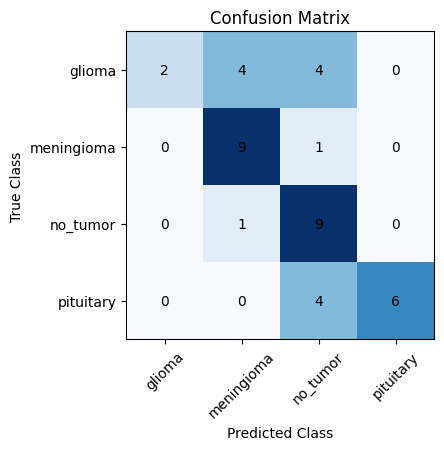

In [19]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(decoded_validation_labels, decoded_predicted_labels)
class_label = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

plt.figure(figsize=(5, 4))
plt.imshow(confusion_mat, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')


# Add class labels as ticks
tick_marks = np.arange(len(class_label))
plt.xticks(tick_marks, class_label, rotation=45)
plt.yticks(tick_marks, class_label)

# Add count values in each cell
for i in range(len(class_label)):
    for j in range(len(class_label)):
        plt.text(j, i, confusion_mat[i, j], ha='center', va='center', color='black')



plt.show()

## Summary and Conclusion
In summary, in our task of classifying brain MRI data, we created a Convolutional Neural Network (CNN) model. The model performed well overall, as seen by its training accuracy of 0.99 and loss of 0.01 and validation accuracy of 0.89, and a validation loss of 0.5. However, we found that the model's performance, notably in classifying glioma, was below average.
We created a confusion matrix to examine the model's performance in more detail. We noticed from the confusion matrix that the model had trouble correctly classifying glioma cases. This shows that there might be a problem with class imbalance or insufficient glioma sample representation in the training data. Due to its complex features or resemblances to other brain structures, glioma may be a more difficult class to detect. To solve this issue, we may consider collecting more glioma samples.  

In summary, the CNN model performs admirably overall, with high accuracy and minimal loss. However, more work needs to be done to accurately classify gliomas. To achieve an overall accurate classification across all classes in the brain MRI scans, further optimization and refinement may be required, as well as a sufficient representation of glioma samples.


